# Taller Deep Learning Obligatorio

## Participantes
* Martin Martinez: 344567
* Rodrigo Paz: 325277



In [1]:
# Importamos todas las dependencias
from matplotlib import pyplot as plt
import os
from pathlib import Path
from SegmentationDataset import SegmentacionDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from typing import Callable, Optional
import numpy as np
from UNet import UNet
from utils import (
    train,
    plot_taining,
    model_classification_report
)


/opt/anaconda3/envs/pytorch_m1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 34
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
#Declaramos todas las variables globales y los hiper parametros del modelo
DEVICE = "cpu"
if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"

NUM_WORKERS = 0 if DEVICE == "mps" else max(os.cpu_count() - 1, 1)  #número de workers para cargar los datos a menos que estemos corriendo en Mac OS
BATCH_SIZE = 128  # tamaño del batch
IMAGE_PATTERN = "*.JPEG"

print(f"Device: {DEVICE}")
print(f"Num Workers: {NUM_WORKERS}")

Device: mps
Num Workers: 0


### Dataset
Los datos provistos en la competencia de Kaggel, para cada muestra se tiene la imagen en formato PNG, en un tamaño fijo 800x800 y por separado tenemos en otra carpeta el resultado esperado de esta muestra. Crearemos un Dataset propio para cargar los X, Y

In [4]:


TRAIN_DATA_DIR = Path('small-segmentation/train') #Path('tdl-segmentacion/train')


def create_train_val_datasets(
    validation_percentage: float = 0.2,
    transform: Optional[Callable] = None
):
    full_train_dataset = SegmentacionDataset(
        root_dir = TRAIN_DATA_DIR,
        load_mask = True,
        transform = transform 
    )
    return random_split(
        full_train_dataset,
        [1 - validation_percentage, validation_percentage],
        generator = torch.Generator().manual_seed(SEED)
    )

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

test_dataset, _ = create_train_val_datasets(transform = transform)
test_loader = DataLoader(
        test_dataset,
        batch_size=100,
        shuffle=True,
        num_workers=NUM_WORKERS,
    )


images, masks = next(iter(test_loader))
image = images[1]
mask = masks[1]

print(f'{type(image)=},{type(mask)=}')



type(image)=<class 'torch.Tensor'>,type(mask)=<class 'torch.Tensor'>


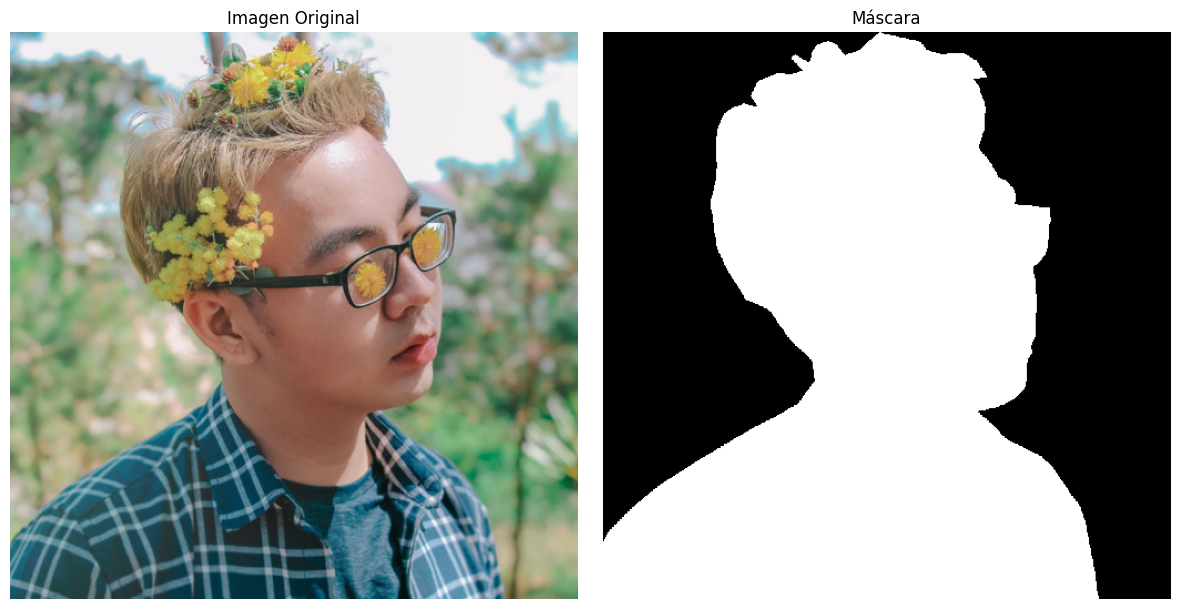

In [5]:
# Creamos una funcion que nos muestre la imagen original y su mascara

def plot_image_with_mask(
    image,
    mask
):
    """
    Muestra la imagen original y a su lado su respectiva mascara. Se asume que tanto la imagen y la mascara tienen el mismo tamaño
    """
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.squeeze(0).numpy()
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Mostrar la imagen original
    axs[0].imshow(image_np)
    axs[0].set_title("Imagen Original")
    axs[0].axis('off')
    axs[1].imshow(mask_np, cmap='gray')
    axs[1].set_title("Máscara")
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()

plot_image_with_mask(image, mask)

### Generamos el modelo de U-Net

In [6]:
model = UNet(input_channel=3, out_channel=1, layer_channels=[64, 128, 256]).to(DEVICE)
IMAGE_SIZE = (240, 240)
BATCH_SIZE = 8
summary(model, input_size=(BATCH_SIZE, 3, *IMAGE_SIZE))
# summary(model, input_size=(3, *IMAGE_SIZE))

layers_pairs=[(256, 128), (128, 64), (64, 64)]
UNetLayer 5: output.shape=torch.Size([8, 128, 120, 120]), type(output)=<class 'torch.Tensor'>
UNetLayer 5: output.shape=torch.Size([8, 64, 240, 240]), type(output)=<class 'torch.Tensor'>
UNetLayer 5: output.shape=torch.Size([8, 1, 240, 240]), type(output)=<class 'torch.Tensor'>


Layer (type:depth-idx)                             Output Shape              Param #
UNet                                               [8, 1, 240, 240]          --
├─UNetLayer: 1-1                                   [8, 1, 240, 240]          --
│    └─UNetNode: 2-1                               [8, 64, 240, 240]         --
│    │    └─Conv2d: 3-1                            [8, 64, 240, 240]         1,792
│    │    └─Conv2d: 3-2                            [8, 64, 240, 240]         36,928
│    │    └─MaxPool2d: 3-3                         [8, 64, 120, 120]         --
│    └─UNetLayer: 2-2                              [8, 64, 240, 240]         --
│    │    └─UNetNode: 3-4                          [8, 128, 120, 120]        221,440
│    │    └─UNetLayer: 3-5                         [8, 128, 120, 120]        1,016,448
│    │    └─UNetNode: 3-6                          [8, 128, 120, 120]        475,456
│    └─UNetNode: 2-3                               [8, 64, 240, 240]         --
│    │    └

In [7]:
CRITERION = nn.CrossEntropyLoss().to(DEVICE)

def log(epoch, train_loss, val_loss):
    print({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor()
])

train_dataset, val_dataset = create_train_val_datasets(transform = transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

model = UNet(input_channel=3, out_channel=1, layer_channels=[64, 128, 256])

train_errors_ln_da, val_errors_ln_da = train(
    model = model,
    optimizer = optim.Adam(model.parameters(), lr=0.003),
    criterion = CRITERION,
    train_loader = train_loader,
    val_loader = val_loader,
    device = DEVICE,
    do_early_stopping = True,
    patience = 3,
    epochs = 3,
    log_fn = log,
    log_every=1
)

layers_pairs=[(256, 128), (128, 64), (64, 64)]
UNetLayer 5: output.shape=torch.Size([6, 128, 120, 120]), type(output)=<class 'torch.Tensor'>
UNetLayer 5: output.shape=torch.Size([6, 64, 240, 240]), type(output)=<class 'torch.Tensor'>
UNetLayer 5: output.shape=torch.Size([6, 1, 240, 240]), type(output)=<class 'torch.Tensor'>
Epoch: 001 | Batch Loss: -0.00000 | Train Loss: 0.00000
UNetLayer 5: output.shape=torch.Size([1, 128, 120, 120]), type(output)=<class 'torch.Tensor'>
UNetLayer 5: output.shape=torch.Size([1, 64, 240, 240]), type(output)=<class 'torch.Tensor'>
UNetLayer 5: output.shape=torch.Size([1, 1, 240, 240]), type(output)=<class 'torch.Tensor'>
{'epoch': 0, 'train_loss': 0.0, 'val_loss': 0.0}
UNetLayer 5: output.shape=torch.Size([6, 128, 120, 120]), type(output)=<class 'torch.Tensor'>
UNetLayer 5: output.shape=torch.Size([6, 64, 240, 240]), type(output)=<class 'torch.Tensor'>
UNetLayer 5: output.shape=torch.Size([6, 1, 240, 240]), type(output)=<class 'torch.Tensor'>
Epoch: 002 